In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import sys

sys.path.append('..')
import interpolator
import pyvo

import sys, os
wdmodels_dir = os.environ['WDMODELS_DIR']
sys.path.append(wdmodels_dir)
import WD_models

plt.style.use('stefan.mplstyle')

In [2]:
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select top 1000 *
        from \"J/MNRAS/508/3877/maincat\"
        where TeffH is not NULL and MassH is not NULL"""
ngfdata = tap_service.search(QUERY).to_table().to_pandas()

In [3]:
def fit_row(row : pd.Series, interp : interpolator.WarwickPhotometry):
    plx, zp, av = row.Plx, row.ZPcor, row.meanAV
    dist = 1000 / (plx + zp)
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    fluxes, e_fluxes = interpolator.fit.mag_to_flux(mags, e_mags, interp.bands)
    res = interpolator.fit.coarse_fit(flux = fluxes, e_flux = e_fluxes, interp = interp, distance = dist, av = av,
                p0 = [10000, 0.012, 0.6], coarse_kws = {'method':'leastsq'})
    return res

interp = interpolator.WarwickPhotometry(model='1d_da_nlte', bands=['Gaia_G', 'Gaia_BP', 'Gaia_RP'], speckws={'wavl_range' : (1000,14000)})
values = np.zeros((len(ngfdata), 6))
for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    res = fit_row(row, interp)
    teff, radius, distance = res.params['teff'].value, res.params['radius'].value, res.params['distance'].value
    av, mass = res.params['av'].value, res.params['mass'].value
    values[i,0] = row.GaiaEDR3
    values[i,1] = teff
    values[i,2] = radius
    values[i,3] = distance
    values[i,4] = av
    values[i,5] = mass
leastsq = pd.DataFrame(values, columns=['GaiaEDR3', 'teff', 'radius', 'distance', 'av', 'mass'])

100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]


In [4]:
def interpolate_massteff(massarray : np.array, teffarray : np.array, Hlayer : str = 'thick') -> np.array:
    """compute the radial velocity from mass and effective temperature
    """
    assert Hlayer in ['thick', 'thin'], 'Hlayer must be either "thick" or "thin"'
    mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
    font_model = WD_models.load_model('f', 'f', 'f', 'H') if Hlayer == 'thick' else WD_models.load_model('f', 'ft', 'f', 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    mass_teff_to_radius = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    radius = mass_teff_to_radius(massarray, teffarray)
    return radius

ngfdata['RadiusH'] = interpolate_massteff(ngfdata.MassH.values, ngfdata.TeffH.values, Hlayer = 'thick')

In [5]:
comparison = pd.merge(leastsq, ngfdata, on='GaiaEDR3')
comparison['teff_pct_err'] = (comparison.teff - comparison.TeffH) / comparison.teff * 100
comparison['radius_pct_err'] = (comparison.radius - comparison.RadiusH) / comparison.radius * 100
comparison['av_pct_err'] = (comparison.av - comparison.meanAV) / comparison.av * 100
comparison['distance_pct_err'] = (comparison.distance - comparison.rgeo) / comparison.distance * 100
comparison['mass_pct_err'] = (comparison.mass - comparison.MassH) / comparison.mass * 100
comparison[['GaiaEDR3', 'teff', 'TeffH', 'radius', 'RadiusH', 'mass', 'MassH']]

,GaiaEDR3,teff,TeffH,radius,RadiusH,mass,MassH
0,7.469807e+13,6030.377709,5966.81,0.009070,0.009347,0.6,0.871187
1,1.529352e+14,12723.518014,12593.00,0.016118,0.015922,0.6,0.443342
2,2.519256e+14,5959.539138,5887.61,0.017138,0.016649,0.6,0.360182
3,2.626802e+14,8550.875157,8368.14,0.008575,0.008935,0.6,0.915358
4,2.881751e+14,12706.150556,12615.33,0.013441,0.013653,0.6,0.561164
...,...,...,...,...,...,...,...
995,4.368861e+16,11141.461960,10990.61,0.012228,0.012432,0.6,0.634610
996,4.375513e+16,5162.268048,5129.08,0.013067,0.013466,0.6,0.519751
997,4.383595e+16,6902.774144,6819.83,0.011454,0.011780,0.6,0.664851
998,4.384145e+16,21851.541399,23970.28,0.012070,0.011124,0.6,0.770208


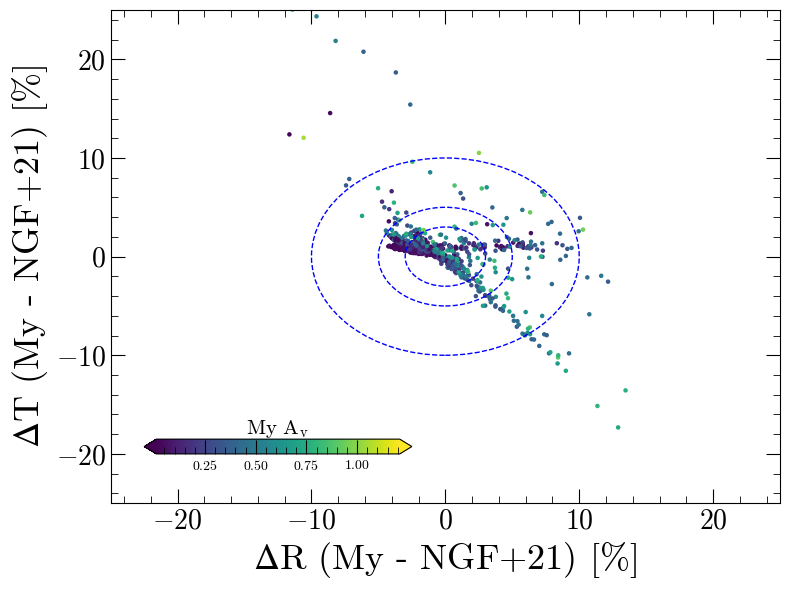

In [13]:
import matplotlib.patches as patches

fig, ax = plt.subplots(ncols=1, figsize=(8,6), sharey=False)
#ax[0].hexbin(comparison.radius_pct_err, comparison.teff_pct_err, bins='log')
scatter_mass = ax.scatter(comparison.radius_pct_err, comparison.teff_pct_err, c = comparison.av, s=5, cmap='viridis')
confidence_ellipses = [3, 5, 10]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax.add_patch(circle)
ax.set_xlabel(r'$\Delta R$ (My - NGF+21) [%]')
ax.set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)

cbaxes = ax.inset_axes([.05, .10, .4, .03]) 
cb = fig.colorbar(scatter_mass, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"My $A_v$ ", size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

fig.tight_layout()

Text(0, 0.5, '$G_\\text{abs}$')

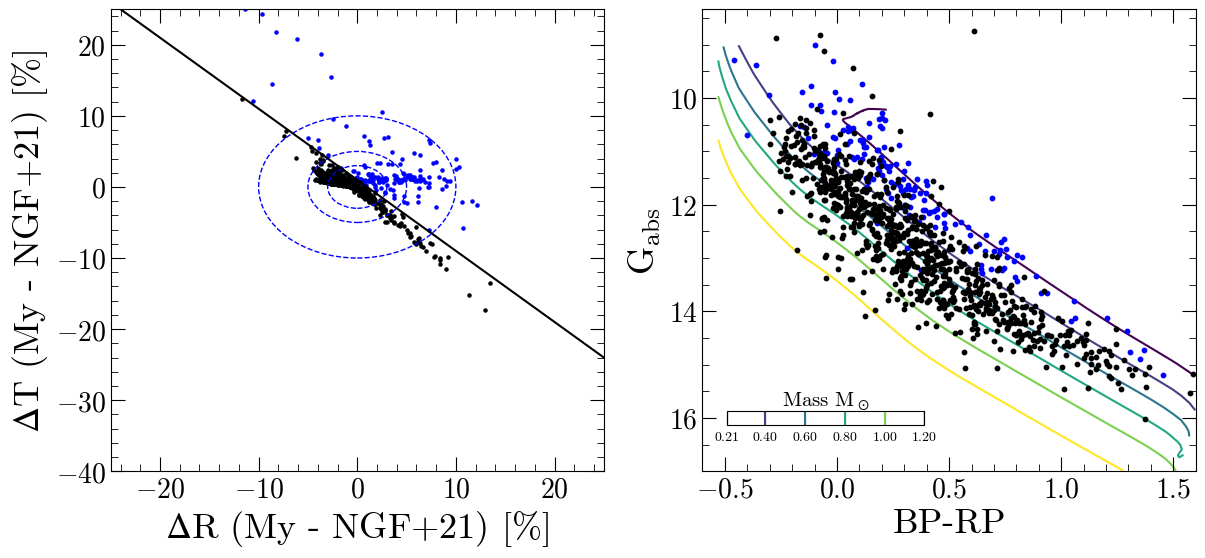

In [19]:
line = lambda x : -x + 1
temp1 = comparison.query(f"teff_pct_err > -radius_pct_err + 1")
temp2 = comparison.query(f"teff_pct_err <= -radius_pct_err + 1")

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
#ax[0].hexbin(comparison.radius_pct_err, comparison.teff_pct_err, bins='log')
ax[0].scatter(temp1.radius_pct_err, temp1.teff_pct_err, c = 'blue', s=5)
ax[0].scatter(temp2.radius_pct_err, temp2.teff_pct_err, c = 'k', s=5)
xlims, ylims = np.array(ax[0].get_xlim()), np.array(ax[0].get_ylim())
ax[0].plot([-50, 50], line(np.array([-50, 50])), c='k')
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
confidence_ellipses = [3, 5, 10]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax[0].add_patch(circle)
ax[0].set_xlabel(r'$\Delta R$ (My - NGF+21) [%]')
ax[0].set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax[0].set_xlim(-25,25)
ax[0].set_ylim(-40,25)

HR_grid = (-0.6, 1.6, 0.002, 9, 17, 0.01)
model = WD_models.load_model('f', 'f', 'f', 'H', HR_grid=HR_grid)
extent = (HR_grid[0], HR_grid[1], HR_grid[3], HR_grid[4])
cs_da = ax[1].contour(model['grid_HR_to_mass'].T, extent=extent, levels = [0.21,0.4,0.6,0.8,1.0,1.2], cmap='viridis', zorder=0)

cbaxes = ax[1].inset_axes([.05, .1, .4, .03]) 
cb = fig.colorbar(cs_da, cax=cbaxes, orientation='horizontal', extend="both", spacing='proportional')
cb.set_label(label=r"Mass $M_\odot$", size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

ax[1].scatter(temp1.BPmag - temp1.RPmag, temp1.Gmag - 5*np.log10(temp1.rgeo) + 5, s = 10, c='blue')
ax[1].scatter(temp2.BPmag - temp2.RPmag, temp2.Gmag - 5*np.log10(temp2.rgeo) + 5, s = 10, c='k')
ax[1].invert_yaxis()
ax[1].set_xlabel("BP-RP")
ax[1].set_ylabel(r"$G_\text{abs}$")